# Description
This code implements the tight-binding model for an axion insulator as described in Appendix A of "Theory of orbital magnetoelectric response", Andrei Malashevich et al 2010 New J. Phys. 12 053032 

In [ ]:
from pythtb import *
from wanpy.wpythtb import Model, Bloch
from models import Haldane
import numpy as np

In [ ]:
from collections import defaultdict

def get_neighbors(orb_vecs, lat_vecs):
    lat_trans = np.array([[0, 0, 0], [-1, 0, 0], [0, -1, 0], [0, 0, -1], [1, 0, 0], [0, 1, 0], [0, 0, 1]]) @ lat_vecs
    nbrs = {}
    # reference site
    for i, orb_i in enumerate(orb_vecs):
        # neighbor site
        for j, orb_j in enumerate(orb_vecs):
            # lattice translation
            for k, trans in enumerate(lat_trans):
                orb_j_trans = np.array(orb_j) + trans
                diff = orb_j_trans - orb_i
                dist = np.linalg.norm(diff)
                nbrs[(i, j, k)] = {
                    'orb_i': orb_i,
                    'orb_j': orb_j,
                    'lat translation': trans,
                    'pos_i': orb_i,
                    'pos_j': orb_j_trans,
                    'diff': diff,
                    'dist': dist,
                }

    # list type with keys corresponding to i'th site and values being all its neighbors 
    # in current and adjacent unit cells
    grouped = defaultdict(list)
    for key, val in nbrs.items():
        grouped[key[0]].append((key, val))

    # for every site, sort its neighbors by distance
    for _, items in grouped.items():
        sorted_items = sorted(items, key=lambda x: x[1]['dist'])

        # group neighbors by distance
        rank_groups = defaultdict(list)
        for key, val in sorted_items:
            rank_groups[val['dist']].append((key, val))

        # for each group of neighbors, assign a rank
        for rank, (dist, group) in enumerate(sorted(rank_groups.items()), start=0):
            for key, val in group:
                val['neighbor_rank'] = rank
    
    return grouped


def axion_ins(Ei, phix, phiy, phiz, t=1):
    lat = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    orb = [[0, 0, 0]]

    model = Model(3, 3, lat, orb)

    # 2x2x2 supercell
    model = model.make_supercell([[2, 0, 0], [0, 2, 0], [0, 0, 2]])

    model.set_onsite(Ei, mode='reset')

    nbrs = get_neighbors(model.get_orb_vecs(Cartesian=True), model.get_lat_vecs())
    nn_vecs = [[0, 0, 0], [-1, 0, 0], [0, -1, 0], [0, 0, -1], [1, 0, 0], [0, 1, 0], [0, 0, 1]]

    for i, nbrs in nbrs.items():
        for nbr in nbrs:
            data = nbr[1]
            key = nbr[0]
            if data['neighbor_rank'] == 1:
                j = key[1]
                lvec = nn_vecs[key[2]]
                if np.array_equal(data['diff'], np.array([1, 0, 0])):
                    model.set_hop(t * np.exp(1j * phix[i]), i, j, lvec, mode='set')
                elif np.array_equal(data['diff'], np.array([0, 1, 0])):
                    model.set_hop(t * np.exp(1j * phiy[i]), i, j, lvec, mode='set')
                elif np.array_equal(data['diff'], np.array([0, 0, 1])):
                    model.set_hop(t * np.exp(1j * phiz[i]), i, j, lvec, mode='set')

    return model

In [ ]:
Ei = [-6.5, -6.0, 1.2, 1.2, 0.9, 1.5, 1.4, 0.8]
phix = np.array([0, 1.4, 0.3, 1.9, 1.3, 0.6, 0.8, 0.8])*np.pi
phiy = np.array([0.5, 0.8, 1.9, 0.3, 0.2, 1.7, 1.4, 0.6])*np.pi
phiz = np.array([1.7, 0.3, 1.0, 1.4, 0.5, 0.7, 0.6, 1.2])*np.pi

ax_ins = axion_ins(Ei, phix, phiy, phiz)
# ax_ins.display()

In [ ]:
nbrs = get_neighbors(ax_ins.get_orb_vecs(Cartesian=True), ax_ins.get_lat_vecs())
# nbrs

In [ ]:
k_path = [[0, 0, 0],[0.5, 0, 0], [0.5, 0.5, 0],[0, 0, 0], [0.5, 0.5, 0.5]]
k_label = (r'$\Gamma $', r'$X$', r'$M$', r'$\Gamma $', r'$R$')

fig, ax = ax_ins.plot_bands(k_path, k_label=k_label, title='Axion Insulator', lw=2 , lc='k')
ax.set_ylim(-9.25, 6.25)
ax.set_yticks([-9, -6, -3, 0, 3, 6])

Qualitatively reproduces figure A.1

 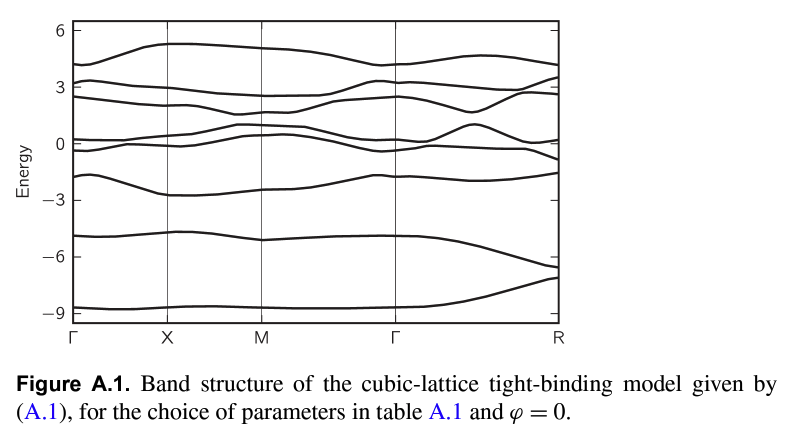


# Berry Curvature

In [ ]:
ax_wfs = Bloch(ax_ins, 20,20,20)
ax_wfs.solve_model()

In [ ]:
Berry_flux = ax_wfs.berry_flux_plaq()

In [ ]:
Berry_flux.shape

In [ ]:
# Berry_flux[0,2]

In [ ]:
np.allclose(Berry_flux[0,2], -Berry_flux[2,0])